# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [114]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [115]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [116]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [117]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [118]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [7]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [119]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [120]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [121]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [122]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [123]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [124]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [125]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [126]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [127]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████| 364173/364173 [04:02<00:00, 1503.30it/s]


In [128]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

# [4] Featurization

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format.
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### Data Sampling:

In [129]:
final['cleaned_text'] = preprocessed_reviews

In [130]:
# When I selected 20K points, Memory Error exception raised when I applied KNN Brute Force on Bow,so selecting 10k points
positive_data = final[final['Score']==1].sample(n=5000)
negative_data = final[final['Score']==0].sample(n=5000)
final_data = pd.concat([positive_data,negative_data])
print(final_data.shape)

(10000, 11)


In [131]:
#Inputdata:Text,Class_Label:Score
X = final_data['cleaned_text'].values
Y = final_data['Score'].values
print("X:",X.shape,type(X))
print("Y:",Y.shape,type(Y))

X: (10000,) <class 'numpy.ndarray'>
Y: (10000,) <class 'numpy.ndarray'>


In [132]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)
X_train,X_cv,Y_train,Y_cv = train_test_split(X,Y,test_size=0.2,random_state=0)
print("After Splitting the Data: ")
print("Train:",X_train.shape,Y_train.shape)
print("Test:",X_test.shape,Y_test.shape)
print("Cross Validation:",X_cv.shape,Y_cv.shape)

After Splitting the Data: 
Train: (8000,) (8000,)
Test: (2000,) (2000,)
Cross Validation: (2000,) (2000,)


### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [133]:
vect=CountVectorizer()
vect=vect.fit(X_train) #we fit ONLY on Train data
X_train_bow=vect.transform(X_train)
X_cv_bow=vect.transform(X_cv)
X_test_bow=vect.transform(X_test)
print("BOW:After Transforming ")
print("X-Train-Bow: ",X_train_bow.shape)
print("X-CV-Bow: ",X_cv.shape)
print("X_Test-Bow: ",X_test.shape)

BOW:After Transforming 
X-Train-Bow:  (8000, 18687)
X-CV-Bow:  (2000,)
X_Test-Bow:  (2000,)


100%|██████████████████████████████████████████| 12/12 [02:28<00:00, 12.35s/it]


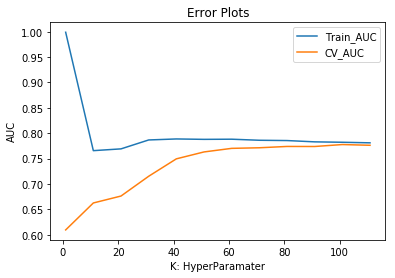

In [134]:

train_auc=[]
cv_auc=[]
K = list(range(1,120,10))
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    neigh.fit(X_train_bow,Y_train)
    Y_train_pred= neigh.predict_proba(X_train_bow)[:,1]
    Y_cv_pred = neigh.predict_proba(X_cv_bow)[:,1]
    #we append the predicted values to train_auc & cv_auc list
    train_auc.append(roc_auc_score(Y_train,Y_train_pred)) #Train data predictions
    cv_auc.append(roc_auc_score(Y_cv,Y_cv_pred)) #Cross Validation data predictions
    
#Will  plolt Error plots between Train and CV Data predictions
plt.plot(K,train_auc,label='Train_AUC')
plt.plot(K,cv_auc,label='CV_AUC')
plt.legend()
plt.xlabel("K: HyperParamater")
plt.ylabel("AUC")
plt.title("Error Plots")
plt.show()

In [26]:
#Based on the above plot we can see that optimal K lies between 75 - 100
# we will calucalte cross-validation scores of k in range of 75-100
from sklearn.model_selection import cross_val_score

neighb = list(range(75,100,2))
cv_score = []
for i in tqdm(neighb):
    knn=KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    scores=cross_val_score(knn,X_train_bow,Y_train,cv=10,scoring='accuracy')
    cv_score.append(scores.mean())

100%|██████████████████████████████████████████| 13/13 [00:43<00:00,  3.33s/it]


Optimal-K:  65


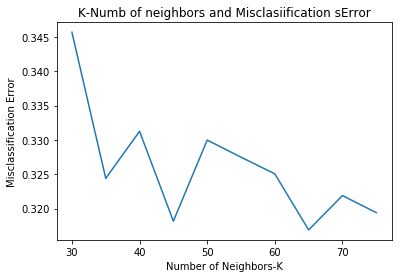

Misclassification error for each K:  [0.346 0.324 0.331 0.318 0.33  0.327 0.325 0.317 0.322 0.319]


In [135]:
#Will calculate Misclassification Error
MSE = [1 -x for x in cv_score]
optimal_k=neighb[MSE.index(min(MSE))]
print("Optimal-K: ",optimal_k)

#Plotting Misclassification vs K
plt.plot(neighb,MSE)
plt.title('K-Numb of neighbors and Misclasiification sError')
plt.xlabel('Number of Neighbors-K')
plt.ylabel('Misclassification Error')
plt.show()

print("Misclassification error for each K: ",np.round(MSE,3))

In [136]:
from sklearn.metrics import accuracy_score

#Now will instantiate learning model with optimal K
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')
#Fitting the model
knn_optimal.fit(X_train_bow,Y_train)
#will predict the response on test data
pred=knn_optimal.predict(X_test_bow)

#Evaluating accuracy now
train_acc = knn_optimal.score(X_train_bow,Y_train)
train_err = 1 - train_acc
test_acc  = accuracy_score(Y_test,pred)
test_err  = 1 - test_acc

print("Training Accuracy: ",train_acc)
print("Training Error:    ",train_err)
print("Testing Accuracy:  ",test_acc)
print("Testing Error:     ",test_err)

Training Accuracy:  0.716
Training Error:     0.28400000000000003
Testing Accuracy:   0.697
Testing Error:      0.30300000000000005


Text(0.5,1,'AUC - Error Plots')

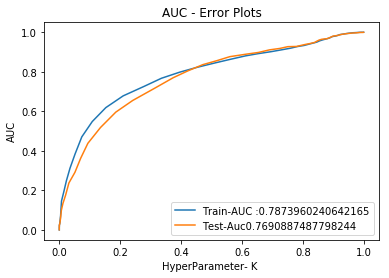

In [138]:
#https://www.programcreek.com/python/example/81207/sklearn.metrics.roc_curve
#Will Plot the Area Under Curve(AUC)

train_fpr,train_tpr,thresholds = roc_curve(Y_train,knn_optimal.predict_proba(X_train_bow)[:,1] )
test_fpr,test_tpr,thresholds = roc_curve(Y_test,knn_optimal.predict_proba(X_test_bow)[:,1])
plt.plot(train_fpr,train_tpr,label='Train-AUC :'+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label='Test-Auc'+str(auc(test_fpr,test_tpr)))
AUC1=str(auc(test_fpr,test_tpr))
plt.legend()
plt.xlabel("HyperParameter- K ")
plt.ylabel("AUC")
plt.title("AUC - Error Plots")

In [139]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Train Confusion Matrix")
print(confusion_matrix(Y_train,knn_optimal.predict(X_train_bow)))
print("Test Confusion Matrix")
print(confusion_matrix(Y_test,knn_optimal.predict(X_test_bow)))

Train Confusion Matrix
[[2650 1338]
 [ 934 3078]]
Test Confusion Matrix
[[633 379]
 [227 761]]


In [140]:
#Classification Report:
from sklearn.metrics import classification_report
print(classification_report(Y_test,pred))

             precision    recall  f1-score   support

          0       0.74      0.63      0.68      1012
          1       0.67      0.77      0.72       988

avg / total       0.70      0.70      0.70      2000



### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [141]:
tf_idf_vect =TfidfVectorizer(ngram_range=(1,2),min_df=5)
tf_idf_vect.fit(X_train)#fit ONLY on Train data
X_train_tfidf=tf_idf_vect.transform(X_train)
X_cv_tfidf=tf_idf_vect.transform(X_cv)
X_test_tfidf=tf_idf_vect.transform(X_test)
print("Train-TfIdf: ",X_train_tfidf.shape)
print("CV-TfIDF: ",X_cv_tfidf.shape)
print("Test-TfIdf",X_test_tfidf.shape)

Train-TfIdf:  (8000, 10936)
CV-TfIDF:  (2000, 10936)
Test-TfIdf (2000, 10936)


100%|██████████████████████████████████████████| 45/45 [03:36<00:00,  4.80s/it]


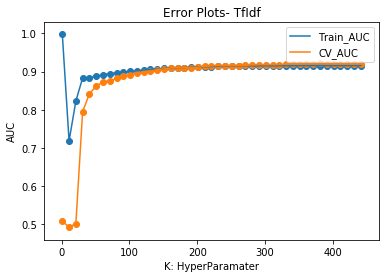

In [142]:

train_auc=[]
cv_auc=[]
K = list(range(1,450,10))
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    neigh.fit(X_train_tfidf,Y_train)
    Y_train_pred= neigh.predict_proba(X_train_tfidf)[:,1]
    Y_cv_pred = neigh.predict_proba(X_cv_tfidf)[:,1]
    #we append the predicted values to train_auc & cv_auc list
    train_auc.append(roc_auc_score(Y_train,Y_train_pred)) #Train data predictions
    cv_auc.append(roc_auc_score(Y_cv,Y_cv_pred)) #Cross Validation data predictions
    
#Will  plolt Error plots between Train and CV Data predictions
plt.plot(K,train_auc,label='Train_AUC')
plt.scatter(K,train_auc)
plt.plot(K,cv_auc,label='CV_AUC')
plt.scatter(K,cv_auc)
plt.legend()
plt.xlabel("K: HyperParamater")
plt.ylabel("AUC")
plt.title("Error Plots- TfIdf")
plt.show()

In [143]:
#Based on the above plot we can see that optimal K lies between 120 - 400
# we will calucalte cross-validation scores of k in range of 75-100
from sklearn.model_selection import cross_val_score

neighb = list(range(120,400,10))
cv_score = []
for i in tqdm(neighb):
    knn=KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    scores=cross_val_score(knn,X_train_tfidf,Y_train,cv=10,scoring='accuracy')
    cv_score.append(scores.mean())

100%|██████████████████████████████████████████| 28/28 [01:50<00:00,  3.95s/it]


Optimal-K:  330


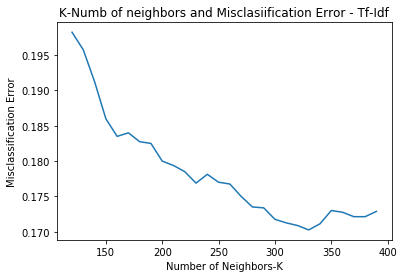

Misclassification error for each K:  [0.198 0.196 0.191 0.186 0.183 0.184 0.183 0.182 0.18  0.179 0.178 0.177
 0.178 0.177 0.177 0.175 0.174 0.173 0.172 0.171 0.171 0.17  0.171 0.173
 0.173 0.172 0.172 0.173]


In [144]:
#Will calculate Misclassification Error
MSE = [1 -x for x in cv_score]
optimal_k2=neighb[MSE.index(min(MSE))]
print("Optimal-K: ",optimal_k2)

#Plotting Misclassification vs K
plt.plot(neighb,MSE)
plt.title('K-Numb of neighbors and Misclasiification Error - Tf-Idf')
plt.xlabel('Number of Neighbors-K')
plt.ylabel('Misclassification Error')
plt.show()

print("Misclassification error for each K: ",np.round(MSE,3))

In [145]:
from sklearn.metrics import accuracy_score

#Now will instantiate learning model with optimal K
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k2,algorithm='brute')
#Fitting the model
knn_optimal.fit(X_train_tfidf,Y_train)
#will predict the response on test data
pred=knn_optimal.predict(X_test_tfidf)

#Evaluating accuracy now
train_acc = knn_optimal.score(X_train_tfidf,Y_train)
train_err = 1 - train_acc
test_acc  = accuracy_score(Y_test,pred)
test_err  = 1 - test_acc

print("Training Accuracy: ",train_acc)
print("Training Error:    ",train_err)
print("Testing Accuracy:  ",test_acc)
print("Testing Error:     ",test_err)

Training Accuracy:  0.833
Training Error:     0.16700000000000004
Testing Accuracy:   0.8345
Testing Error:      0.16549999999999998


Text(0.5,1,'AUC - Error Plots Tf-Idf')

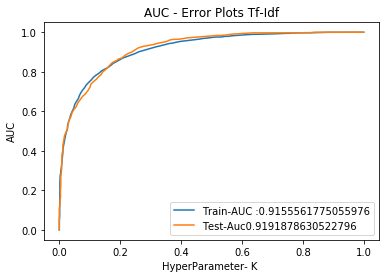

In [146]:
#https://www.programcreek.com/python/example/81207/sklearn.metrics.roc_curve
#Will Plot the Area Under Curve(AUC)

train_fpr,train_tpr,thresholds = roc_curve(Y_train,knn_optimal.predict_proba(X_train_tfidf)[:,1] )
test_fpr,test_tpr,thresholds = roc_curve(Y_test,knn_optimal.predict_proba(X_test_tfidf)[:,1])
plt.plot(train_fpr,train_tpr,label='Train-AUC :'+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label='Test-Auc'+str(auc(test_fpr,test_tpr)))
AUC2=str(auc(test_fpr,test_tpr))
plt.legend()
plt.xlabel("HyperParameter- K ")
plt.ylabel("AUC")
plt.title("AUC - Error Plots Tf-Idf")

In [147]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Train Confusion Matrix -Tf-Idf")
print(confusion_matrix(Y_train,knn_optimal.predict(X_train_tfidf)))
print("Test Confusion Matrix - Tf-Idf")
print(confusion_matrix(Y_test,knn_optimal.predict(X_test_tfidf)))

Train Confusion Matrix -Tf-Idf
[[3281  707]
 [ 629 3383]]
Test Confusion Matrix - Tf-Idf
[[824 188]
 [143 845]]


In [148]:
#Classification Report:
from sklearn.metrics import classification_report
print(classification_report(Y_test,pred))

             precision    recall  f1-score   support

          0       0.85      0.81      0.83      1012
          1       0.82      0.86      0.84       988

avg / total       0.84      0.83      0.83      2000



### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [149]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
#will train our w2v model using the sentences in our train_data
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50,workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  5695
sample words  ['far', 'dog', 'not', 'interested', 'toy', 'sure', 'going', 'concept', 'great', 'guess', 'gotta', 'actually', 'likes', 'work', 'maybe', 'show', 'interest', 'later', 'new', 'toys', 'call', 'product', 'licorice', 'taste', 'gave', 'gas', 'returns', 'says', 'no', 'stuck', 'horrible', 'tasting', 'black', 'bears', 'one', 'review', 'lacking', 'sense', 'buying', 'vine', 'brand', 'throw', 'sugar', 'free', 'trash', 'bin', 'tastes', 'made', 'without', 'eggs']


In [150]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|█████████████████████████████████████| 8000/8000 [00:14<00:00, 535.66it/s]


(8000, 50)
[ 1.98903505e-02 -7.84264062e-02  5.69168688e-01 -2.80875112e-01
  6.16918880e-01  9.91349493e-02 -2.28120751e-01  2.74707291e-01
 -5.28280795e-01  4.38519139e-01 -3.50490403e-01  3.11072335e-01
  3.38056013e-01 -4.24920690e-01 -1.02937617e+00  4.35151724e-01
 -4.57121982e-01  2.16800756e-02  6.99817322e-01  6.13034428e-01
 -3.43008618e-01  2.76334450e-02 -5.16486102e-02  1.07611476e-01
 -9.58413322e-01 -4.76576474e-02  2.16015566e-01  4.74544429e-01
  5.06246629e-05  2.07121821e-01 -1.08373715e-01  3.31075405e-01
 -1.64071650e-01  2.38252273e-01  1.62302948e-01  5.69833656e-01
  3.72628156e-01  1.42750006e-01  4.59265056e-01 -1.20510830e-01
  1.85380803e-03  1.02482017e-01 -3.26564028e-01  1.58690044e-02
  8.83200638e-02  3.21915191e-01 -6.39429111e-01  5.42265625e-02
 -1.18692555e-02  1.65763863e-01]


In [151]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|█████████████████████████████████████| 2000/2000 [00:03<00:00, 526.98it/s]


(2000, 50)
[ 0.07924108 -0.21553846  0.35639653 -0.19694853  0.68202198 -0.04537937
 -0.03289943  0.3207276  -0.63573036  0.52368002 -0.3399201   0.28689481
  0.15173763 -0.62830019 -0.65056583  0.33483969 -0.4675887  -0.04091075
  1.004899    0.57161699 -0.22728517 -0.06107672 -0.22938657  0.00383277
 -0.81217663 -0.10767981  0.26354733  0.43197711 -0.18454061  0.2204687
 -0.02940543  0.54436233 -0.28441307  0.16282474  0.26317974  0.51738993
  0.26683808  0.07671717  0.40309053 -0.15114304  0.05126396  0.2719937
 -0.21482808 -0.26660862 -0.02969977  0.32961055 -0.41726305  0.13513175
 -0.10612778  0.39632308]


In [152]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|█████████████████████████████████████| 2000/2000 [00:03<00:00, 548.51it/s]


(2000, 50)
[ 0.07924108 -0.21553846  0.35639653 -0.19694853  0.68202198 -0.04537937
 -0.03289943  0.3207276  -0.63573036  0.52368002 -0.3399201   0.28689481
  0.15173763 -0.62830019 -0.65056583  0.33483969 -0.4675887  -0.04091075
  1.004899    0.57161699 -0.22728517 -0.06107672 -0.22938657  0.00383277
 -0.81217663 -0.10767981  0.26354733  0.43197711 -0.18454061  0.2204687
 -0.02940543  0.54436233 -0.28441307  0.16282474  0.26317974  0.51738993
  0.26683808  0.07671717  0.40309053 -0.15114304  0.05126396  0.2719937
 -0.21482808 -0.26660862 -0.02969977  0.32961055 -0.41726305  0.13513175
 -0.10612778  0.39632308]


100%|██████████████████████████████████████████| 20/20 [01:00<00:00,  3.00s/it]


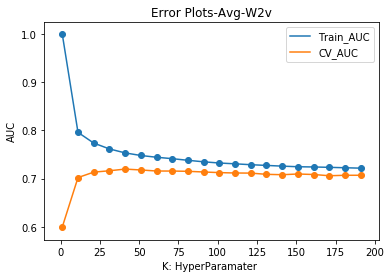

In [153]:

train_auc=[]
cv_auc=[]
K = list(range(1,200,10))
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    neigh.fit(sent_vectors_train,Y_train)
    Y_train_pred= neigh.predict_proba(sent_vectors_train)[:,1]
    Y_cv_pred = neigh.predict_proba(sent_vectors_cv)[:,1]
    #we append the predicted values to train_auc & cv_auc list
    train_auc.append(roc_auc_score(Y_train,Y_train_pred)) #Train data predictions
    cv_auc.append(roc_auc_score(Y_cv,Y_cv_pred)) #Cross Validation data predictions
    
#Will  plolt Error plots between Train and CV Data predictions
plt.plot(K,train_auc,label='Train_AUC')
plt.scatter(K,train_auc)
plt.plot(K,cv_auc,label='CV_AUC')
plt.scatter(K,cv_auc)
plt.legend()
plt.xlabel("K: HyperParamater ")
plt.ylabel("AUC")
plt.title("Error Plots-Avg-W2v")
plt.show()

In [154]:
#Based on the above plot we can see that optimal K lies between 35 - 75
# we will calucalte cross-validation scores of k in range of 35-75
from sklearn.model_selection import cross_val_score

neighb = list(range(35,75,5))
cv_score = []
for i in tqdm(neighb):
    knn=KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    scores=cross_val_score(knn,sent_vectors_train,Y_train,cv=10,scoring='accuracy')
    cv_score.append(scores.mean())

100%|████████████████████████████████████████████| 8/8 [00:14<00:00,  1.84s/it]


Optimal-K:  45


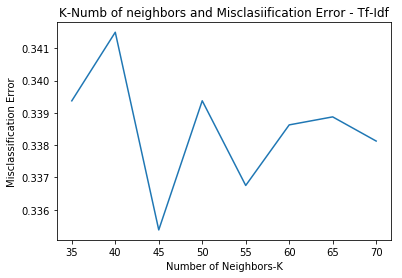

Misclassification error for each K:  [0.339 0.341 0.335 0.339 0.337 0.339 0.339 0.338]


In [155]:
#Will calculate Misclassification Error
MSE = [1 -x for x in cv_score]
optimal_k3=neighb[MSE.index(min(MSE))]
print("Optimal-K: ",optimal_k3)

#Plotting Misclassification vs K
plt.plot(neighb,MSE)
plt.title('K-Numb of neighbors and Misclasiification Error - Tf-Idf')
plt.xlabel('Number of Neighbors-K')
plt.ylabel('Misclassification Error')
plt.show()

print("Misclassification error for each K: ",np.round(MSE,3))

In [156]:
from sklearn.metrics import accuracy_score

#Now will instantiate learning model with optimal K
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k3,algorithm='brute')
#Fitting the model
knn_optimal.fit(sent_vectors_train,Y_train)
#will predict the response on test data
pred=knn_optimal.predict(sent_vectors_test)

#Evaluating accuracy now
train_acc = knn_optimal.score(sent_vectors_train,Y_train)
train_err = 1 - train_acc
test_acc  = accuracy_score(Y_test,pred)
test_err  = 1 - test_acc

print("Training Accuracy: ",train_acc)
print("Training Error:    ",train_err)
print("Testing Accuracy:  ",test_acc)
print("Testing Error:     ",test_err)

Training Accuracy:  0.685875
Training Error:     0.314125
Testing Accuracy:   0.6545
Testing Error:      0.34550000000000003


Text(0.5,1,'AUC - Error Plots Avg W2V')

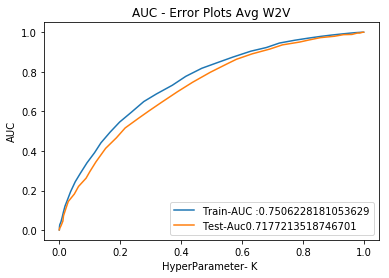

In [158]:
#https://www.programcreek.com/python/example/81207/sklearn.metrics.roc_curve
#Will Plot the Area Under Curve(AUC)

train_fpr,train_tpr,thresholds = roc_curve(Y_train,knn_optimal.predict_proba(sent_vectors_train)[:,1] )
test_fpr,test_tpr,thresholds = roc_curve(Y_test,knn_optimal.predict_proba(sent_vectors_test)[:,1])
plt.plot(train_fpr,train_tpr,label='Train-AUC :'+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label='Test-Auc'+str(auc(test_fpr,test_tpr)))
AUC3=str(auc(test_fpr,test_tpr))
plt.legend()
plt.xlabel("HyperParameter- K ")
plt.ylabel("AUC")
plt.title("AUC - Error Plots Avg W2V")

In [159]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Train Confusion Matrix -Avg W2V")
print(confusion_matrix(Y_train,knn_optimal.predict(sent_vectors_train)))
print("Test Confusion Matrix - Avg W2V")
print(confusion_matrix(Y_test,knn_optimal.predict(sent_vectors_test)))

Train Confusion Matrix -Avg W2V
[[2881 1107]
 [1406 2606]]
Test Confusion Matrix - Avg W2V
[[714 298]
 [393 595]]


In [160]:
#Classification Report:
from sklearn.metrics import classification_report
print(classification_report(Y_test,pred))

             precision    recall  f1-score   support

          0       0.64      0.71      0.67      1012
          1       0.67      0.60      0.63       988

avg / total       0.66      0.65      0.65      2000



### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [161]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [162]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████████████████████████████████| 8000/8000 [01:39<00:00, 80.51it/s]


In [163]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████████████████████████████████| 2000/2000 [00:24<00:00, 80.89it/s]


In [164]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████████████████████████████████| 2000/2000 [00:24<00:00, 80.26it/s]


100%|██████████████████████████████████████████| 20/20 [00:50<00:00,  2.51s/it]


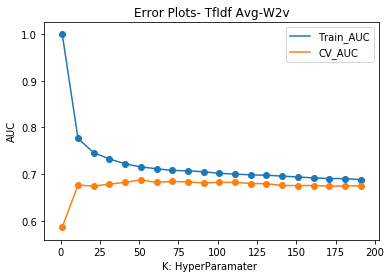

In [165]:

train_auc=[]
cv_auc=[]
K = list(range(1,200,10))
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    neigh.fit(tfidf_sent_vectors_train,Y_train)
    Y_train_pred= neigh.predict_proba(tfidf_sent_vectors_train)[:,1]
    Y_cv_pred = neigh.predict_proba(tfidf_sent_vectors_cv)[:,1]
    #we append the predicted values to train_auc & cv_auc list
    train_auc.append(roc_auc_score(Y_train,Y_train_pred)) #Train data predictions
    cv_auc.append(roc_auc_score(Y_cv,Y_cv_pred)) #Cross Validation data predictions
    
#Will  plolt Error plots between Train and CV Data predictions
plt.plot(K,train_auc,label='Train_AUC')
plt.scatter(K,train_auc)
plt.plot(K,cv_auc,label='CV_AUC')
plt.scatter(K,cv_auc)
plt.legend()
plt.xlabel("K: HyperParamater ")
plt.ylabel("AUC")
plt.title("Error Plots- TfIdf Avg-W2v")
plt.show()

In [166]:
#Based on the above plot we can see that optimal K lies between 35 - 75
# we will calucalte cross-validation scores of k in range of 35-75
from sklearn.model_selection import cross_val_score

neighb = list(range(35,75,5))
cv_score = []
for i in tqdm(neighb):
    knn=KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    scores=cross_val_score(knn,tfidf_sent_vectors_train,Y_train,cv=10,scoring='accuracy')
    cv_score.append(scores.mean())

100%|████████████████████████████████████████████| 8/8 [00:16<00:00,  2.07s/it]


Optimal-K:  60


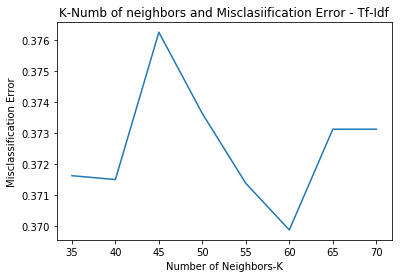

Misclassification error for each K:  [0.372 0.372 0.376 0.374 0.371 0.37  0.373 0.373]


In [167]:
#Will calculate Misclassification Error
MSE = [1 -x for x in cv_score]
optimal_k4=neighb[MSE.index(min(MSE))]
print("Optimal-K: ",optimal_k4)

#Plotting Misclassification vs K
plt.plot(neighb,MSE)
plt.title('K-Numb of neighbors and Misclasiification Error - Tf-Idf')
plt.xlabel('Number of Neighbors-K')
plt.ylabel('Misclassification Error')
plt.show()

print("Misclassification error for each K: ",np.round(MSE,3))

In [168]:
from sklearn.metrics import accuracy_score

#Now will instantiate learning model with optimal K
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k4,algorithm='brute')
#Fitting the model
knn_optimal.fit(tfidf_sent_vectors_train,Y_train)
#will predict the response on test data
pred=knn_optimal.predict(tfidf_sent_vectors_test)

#Evaluating accuracy now
train_acc = knn_optimal.score(tfidf_sent_vectors_train,Y_train)
train_err = 1 - train_acc
test_acc  = accuracy_score(Y_test,pred)
test_err  = 1 - test_acc

print("Training Accuracy: ",train_acc)
print("Training Error:    ",train_err)
print("Testing Accuracy:  ",test_acc)
print("Testing Error:     ",test_err)

Training Accuracy:  0.649375
Training Error:     0.35062499999999996
Testing Accuracy:   0.6385
Testing Error:      0.36150000000000004


Text(0.5,1,'AUC - Error Plots TfIdf Weighted W2V')

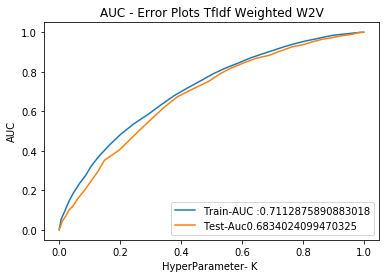

In [170]:
#https://www.programcreek.com/python/example/81207/sklearn.metrics.roc_curve
#Will Plot the Area Under Curve(AUC)

train_fpr,train_tpr,thresholds = roc_curve(Y_train,knn_optimal.predict_proba(tfidf_sent_vectors_train)[:,1] )
test_fpr,test_tpr,thresholds = roc_curve(Y_test,knn_optimal.predict_proba(tfidf_sent_vectors_test)[:,1])
plt.plot(train_fpr,train_tpr,label='Train-AUC :'+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label='Test-Auc'+str(auc(test_fpr,test_tpr)))
AUC4 = str(auc(test_fpr,test_tpr))
plt.legend()
plt.xlabel("HyperParameter- K ")
plt.ylabel("AUC")
plt.title("AUC - Error Plots TfIdf Weighted W2V")

In [171]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Train Confusion Matrix -TfIdf Weighted W2V")
print(confusion_matrix(Y_train,knn_optimal.predict(tfidf_sent_vectors_train)))
print("Test Confusion Matrix - TfIdf Weighted W2V")
print(confusion_matrix(Y_test,knn_optimal.predict(tfidf_sent_vectors_test)))

Train Confusion Matrix -TfIdf Weighted W2V
[[2648 1340]
 [1465 2547]]
Test Confusion Matrix - TfIdf Weighted W2V
[[661 351]
 [372 616]]


In [172]:
#Classification Report:
from sklearn.metrics import classification_report
print(classification_report(Y_test,pred))

             precision    recall  f1-score   support

          0       0.64      0.65      0.65      1012
          1       0.64      0.62      0.63       988

avg / total       0.64      0.64      0.64      2000



## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [173]:
positive_data2=final[final['Score']==1].sample(n=1000)
negative_data2=final[final['Score']==0].sample(n=1000)
final2=pd.concat([positive_data2,negative_data2])

A=final2['cleaned_text'].values
B=final2['Score'].values
print(A.shape,type(A))
print(B.shape,type(B))

(2000,) <class 'numpy.ndarray'>
(2000,) <class 'numpy.ndarray'>


In [174]:
A_train,A_test,B_train,B_test=train_test_split(A,B,test_size=0.2,random_state=10)
A_train,A_cv,B_train,B_cv=train_test_split(A,B,test_size=0.2,random_state=10)
print("After Sampling:")
print("Train Data: ",A_train.shape,B_train.shape)
print("Test Data:  ",A_test.shape,B_test.shape)
print("CV Data:    ",A_cv.shape,B_cv.shape)

After Sampling:
Train Data:  (1600,) (1600,)
Test Data:   (400,) (400,)
CV Data:     (400,) (400,)


In [176]:
# Please write all the code with proper documentation
vect=CountVectorizer(min_df=10,max_features=500)
vect=vect.fit(A_train) #we fit ONLY on Train data
Kd_train_bow=vect.transform(A_train)
Kd_cv_bow=vect.transform(A_cv)
Kd_test_bow=vect.transform(A_test)
print("BOW:After Transforming ")
print("X-Train-Bow: ",Kd_train_bow.shape)
print("X-CV-Bow: ",Kd_cv_bow.shape)
print("X_Test-Bow: ",Kd_test_bow.shape)

BOW:After Transforming 
X-Train-Bow:  (1600, 500)
X-CV-Bow:  (400, 500)
X_Test-Bow:  (400, 500)


100%|██████████████████████████████████████████| 15/15 [00:50<00:00,  3.37s/it]


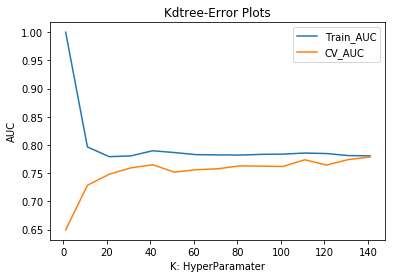

In [177]:

train_auc=[]
cv_auc=[]
K = list(range(1,150,10))
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    neigh.fit(Kd_train_bow.todense(),B_train)
    B_train_pred= neigh.predict_proba(Kd_train_bow.todense())[:,1]
    B_cv_pred = neigh.predict_proba(Kd_cv_bow.todense())[:,1]
    #we append the predicted values to train_auc & cv_auc list
    train_auc.append(roc_auc_score(B_train,B_train_pred)) #Train data predictions
    cv_auc.append(roc_auc_score(B_cv,B_cv_pred)) #Cross Validation data predictions
    
#Will  plolt Error plots between Train and CV Data predictions
plt.plot(K,train_auc,label='Train_AUC')
plt.plot(K,cv_auc,label='CV_AUC')
plt.legend()
plt.xlabel("K: HyperParamater")
plt.ylabel("AUC")
plt.title("Kdtree-Error Plots")
plt.show()

In [178]:
#Based on the above plot we can see that optimal K lies between 30 - 80
# we will calucalte cross-validation scores of k in range of 30-80
from sklearn.model_selection import cross_val_score

neighb = list(range(30,80,5))
cv_score = []
for i in tqdm(neighb):
    knn=KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    scores=cross_val_score(knn,Kd_train_bow.todense(),B_train,cv=10,scoring='accuracy')
    cv_score.append(scores.mean())

100%|██████████████████████████████████████████| 10/10 [00:30<00:00,  3.06s/it]


Optimal-K:  75


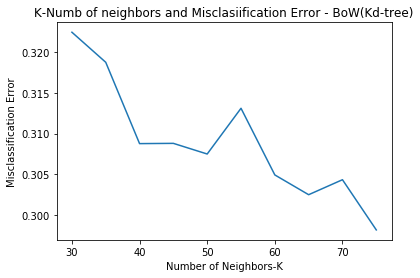

Misclassification error for each K:  [0.322 0.319 0.309 0.309 0.307 0.313 0.305 0.302 0.304 0.298]


In [179]:
#Will calculate Misclassification Error
MSE = [1 -x for x in cv_score]
optimal_k5=neighb[MSE.index(min(MSE))]
print("Optimal-K: ",optimal_k5)

#Plotting Misclassification vs K
plt.plot(neighb,MSE)
plt.title('K-Numb of neighbors and Misclasiification Error - BoW(Kd-tree)')
plt.xlabel('Number of Neighbors-K')
plt.ylabel('Misclassification Error')
plt.show()

print("Misclassification error for each K: ",np.round(MSE,3))

In [196]:
from sklearn.metrics import accuracy_score

#Now will instantiate learning model with optimal K
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k5,algorithm='kd_tree')
#Fitting the model
knn_optimal.fit(Kd_train_bow.todense(),B_train)
#will predict the response on test data
pred=knn_optimal.predict(Kd_test_bow.todense())

#Evaluating accuracy now
train_acc = knn_optimal.score(Kd_train_bow.todense(),B_train)
train_err = 1 - train_acc
test_acc  = accuracy_score(B_test,pred)
test_err  = 1 - test_acc

print("Training Accuracy: ",train_acc)
print("Training Error:    ",train_err)
print("Testing Accuracy:  ",test_acc)
print("Testing Error:     ",test_err)

Training Accuracy:  0.715
Training Error:     0.28500000000000003
Testing Accuracy:   0.685
Testing Error:      0.31499999999999995


Text(0.5,1,'AUC - Error Plots W2V-Kdtree')

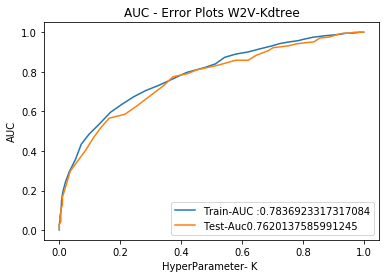

In [197]:
#https://www.programcreek.com/python/example/81207/sklearn.metrics.roc_curve
#Will Plot the Area Under Curve(AUC)

train_fpr,train_tpr,thresholds = roc_curve(B_train,knn_optimal.predict_proba(Kd_train_bow.todense())[:,1] )
test_fpr,test_tpr,thresholds = roc_curve(B_test,knn_optimal.predict_proba(Kd_test_bow.todense())[:,1])
plt.plot(train_fpr,train_tpr,label='Train-AUC :'+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label='Test-Auc'+str(auc(test_fpr,test_tpr)))
AUC5=str(auc(test_fpr,test_tpr))
plt.legend()
plt.xlabel("HyperParameter- K ")
plt.ylabel("AUC")
plt.title("AUC - Error Plots W2V-Kdtree")

In [198]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Train Confusion Matrix - W2V (Kd-tree)")
print(confusion_matrix(B_train,knn_optimal.predict(Kd_train_bow.todense())))
print("Test Confusion Matrix - W2V (Kd-tree)")
print(confusion_matrix(B_test,knn_optimal.predict(Kd_test_bow.todense())))

Train Confusion Matrix - W2V (Kd-tree)
[[608 197]
 [259 536]]
Test Confusion Matrix - W2V (Kd-tree)
[[145  50]
 [ 76 129]]


In [199]:
#Classification Report:
from sklearn.metrics import classification_report
print(classification_report(B_test,pred))

             precision    recall  f1-score   support

          0       0.66      0.74      0.70       195
          1       0.72      0.63      0.67       205

avg / total       0.69      0.69      0.68       400



### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [184]:
tf_idf_vect =TfidfVectorizer(ngram_range=(1,2),min_df=5,max_df=100)
tf_idf_vect.fit(A_train)#fit ONLY on Train data
Kd_train_tfidf=tf_idf_vect.transform(A_train)
Kd_cv_tfidf=tf_idf_vect.transform(A_cv)
Kd_test_tfidf=tf_idf_vect.transform(A_test)
print("Train-TfIdf: ",Kd_train_tfidf.shape)
print("CV-TfIDF: ",Kd_cv_tfidf.shape)
print("Test-TfIdf",Kd_test_tfidf.shape)

Train-TfIdf:  (1600, 2276)
CV-TfIDF:  (400, 2276)
Test-TfIdf (400, 2276)


100%|██████████████████████████████████████████| 20/20 [04:53<00:00, 14.66s/it]


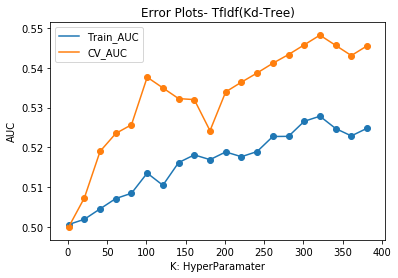

In [187]:

train_auc=[]
cv_auc=[]
K = list(range(1,400,20))
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    neigh.fit(Kd_train_tfidf.todense(),A_train)
    B_train_pred= neigh.predict_proba(Kd_train_tfidf.todense())[:,1]
    B_cv_pred = neigh.predict_proba(Kd_cv_tfidf.todense())[:,1]
    #we append the predicted values to train_auc & cv_auc list
    train_auc.append(roc_auc_score(B_train,B_train_pred)) #Train data predictions
    cv_auc.append(roc_auc_score(B_cv,B_cv_pred)) #Cross Validation data predictions
    
#Will  plolt Error plots between Train and CV Data predictions
plt.plot(K,train_auc,label='Train_AUC')
plt.scatter(K,train_auc)
plt.plot(K,cv_auc,label='CV_AUC')
plt.scatter(K,cv_auc)
plt.legend()
plt.xlabel("K: HyperParamater")
plt.ylabel("AUC")
plt.title("Error Plots- TfIdf(Kd-Tree)")
plt.show()

In [188]:
#Based on the above plot we can see that optimal K lies between 30 - 80
# we will calucalte cross-validation scores of k in range of 30-80
from sklearn.model_selection import cross_val_score

neighb = list(range(110,140,5))
cv_score = []
for i in tqdm(neighb):
    knn=KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    scores=cross_val_score(knn,Kd_train_tfidf.todense(),B_train,cv=10,scoring='accuracy')
    cv_score.append(scores.mean())

100%|████████████████████████████████████████████| 6/6 [01:19<00:00, 13.27s/it]


Optimal-K:  125


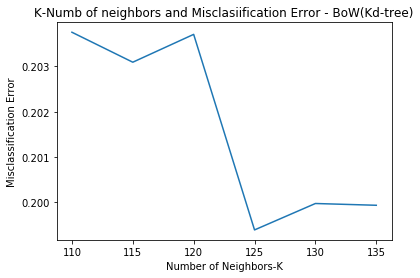

Misclassification error for each K:  [0.204 0.203 0.204 0.199 0.2   0.2  ]


In [189]:
#Will calculate Misclassification Error
MSE = [1 -x for x in cv_score]
optimal_k6=neighb[MSE.index(min(MSE))]
print("Optimal-K: ",optimal_k6)

#Plotting Misclassification vs K
plt.plot(neighb,MSE)
plt.title('K-Numb of neighbors and Misclasiification Error - BoW(Kd-tree)')
plt.xlabel('Number of Neighbors-K')
plt.ylabel('Misclassification Error')
plt.show()

print("Misclassification error for each K: ",np.round(MSE,3))

Optimal-K:  125


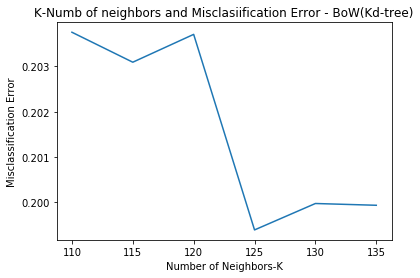

Misclassification error for each K:  [0.204 0.203 0.204 0.199 0.2   0.2  ]


In [190]:
#Will calculate Misclassification Error
MSE = [1 -x for x in cv_score]
optimal_k6=neighb[MSE.index(min(MSE))]
print("Optimal-K: ",optimal_k6)

#Plotting Misclassification vs K
plt.plot(neighb,MSE)
plt.title('K-Numb of neighbors and Misclasiification Error - BoW(Kd-tree)')
plt.xlabel('Number of Neighbors-K')
plt.ylabel('Misclassification Error')
plt.show()

print("Misclassification error for each K: ",np.round(MSE,3))

In [191]:
from sklearn.metrics import accuracy_score

#Now will instantiate learning model with optimal K
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k6,algorithm='kd_tree')
#Fitting the model
knn_optimal.fit(Kd_train_tfidf.todense(),B_train)
#will predict the response on test data
pred=knn_optimal.predict(Kd_test_tfidf.todense())

#Evaluating accuracy now
train_acc = knn_optimal.score(Kd_train_tfidf.todense(),B_train)
train_err = 1 - train_acc
test_acc  = accuracy_score(B_test,pred)
test_err  = 1 - test_acc

print("Training Accuracy: ",train_acc)
print("Training Error:    ",train_err)
print("Testing Accuracy:  ",test_acc)
print("Testing Error:     ",test_err)

Training Accuracy:  0.824375
Training Error:     0.17562500000000003
Testing Accuracy:   0.8125
Testing Error:      0.1875


Text(0.5,1,'AUC - Error Plots Kdtree')

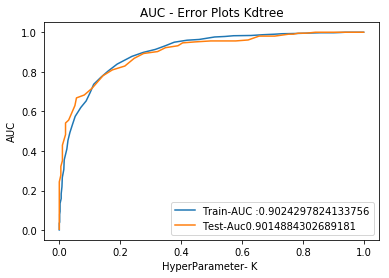

In [193]:
#https://www.programcreek.com/python/example/81207/sklearn.metrics.roc_curve
#Will Plot the Area Under Curve(AUC)

train_fpr,train_tpr,thresholds = roc_curve(B_train,knn_optimal.predict_proba(Kd_train_tfidf.todense())[:,1] )
test_fpr,test_tpr,thresholds = roc_curve(B_test,knn_optimal.predict_proba(Kd_test_tfidf.todense())[:,1])
plt.plot(train_fpr,train_tpr,label='Train-AUC :'+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label='Test-Auc'+str(auc(test_fpr,test_tpr)))
AUC6=str(auc(test_fpr,test_tpr))
plt.legend()
plt.xlabel("HyperParameter- K ")
plt.ylabel("AUC")
plt.title("AUC - Error Plots Kdtree")

In [194]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Train Confusion Matrix - (Kd-tree)")
print(confusion_matrix(B_train,knn_optimal.predict(Kd_train_tfidf.todense())))
print("Test Confusion Matrix -  (Kd-tree)")
print(confusion_matrix(B_test,knn_optimal.predict(Kd_test_tfidf.todense())))

Train Confusion Matrix - (Kd-tree)
[[652 153]
 [128 667]]
Test Confusion Matrix -  (Kd-tree)
[[147  48]
 [ 27 178]]


In [195]:
#Classification Report:
from sklearn.metrics import classification_report
print(classification_report(B_test,pred))

             precision    recall  f1-score   support

          0       0.84      0.75      0.80       195
          1       0.79      0.87      0.83       205

avg / total       0.82      0.81      0.81       400



### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [200]:
# Please write all the code with proper documentation
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
#will train our w2v model using the sentences in our train_data
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50,workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  5695
sample words  ['far', 'dog', 'not', 'interested', 'toy', 'sure', 'going', 'concept', 'great', 'guess', 'gotta', 'actually', 'likes', 'work', 'maybe', 'show', 'interest', 'later', 'new', 'toys', 'call', 'product', 'licorice', 'taste', 'gave', 'gas', 'returns', 'says', 'no', 'stuck', 'horrible', 'tasting', 'black', 'bears', 'one', 'review', 'lacking', 'sense', 'buying', 'vine', 'brand', 'throw', 'sugar', 'free', 'trash', 'bin', 'tastes', 'made', 'without', 'eggs']


In [201]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|█████████████████████████████████████| 8000/8000 [00:15<00:00, 510.01it/s]


(8000, 50)
[ 0.10746644 -0.10364664  0.69517414 -0.32393196  0.64422422  0.18668117
 -0.15057675  0.33395679 -0.49875018  0.44325304 -0.36215763  0.41739563
  0.34131813 -0.30266647 -1.0955833   0.42741713 -0.26353696  0.05928877
  0.55499524  0.53729429 -0.32341965  0.19727824 -0.15882084  0.14895062
 -0.90330084 -0.11297558  0.12938059  0.53768597 -0.14767169  0.19102479
 -0.12138587  0.43090359 -0.14195529  0.11691437  0.18628504  0.6003554
  0.38327763  0.12898771  0.49888377 -0.03912008 -0.04066646  0.20396916
 -0.14101064 -0.08370291  0.24019422  0.31584122 -0.60203988  0.20410701
 -0.12022534  0.26427645]


In [202]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|█████████████████████████████████████| 2000/2000 [00:03<00:00, 525.18it/s]


(2000, 50)
[ 0.13532551 -0.16277947  0.55143809 -0.31362831  0.66809325  0.0190743
  0.01317279  0.37817624 -0.6090533   0.51910429 -0.36624168  0.31794019
  0.16263953 -0.4607444  -0.72904371  0.34156161 -0.23695289  0.03351267
  0.87254602  0.50315643 -0.24973179  0.10657983 -0.32085222 -0.05408672
 -0.76056469 -0.24669665  0.20718289  0.43590597 -0.29509678  0.27853439
  0.07225133  0.53255024 -0.24591978  0.11318636  0.2126896   0.5216273
  0.19542684  0.00874024  0.33390222 -0.11986117  0.15819619  0.34817109
  0.01297902 -0.35308589  0.14578385  0.34627122 -0.39360132  0.30776837
 -0.14456737  0.50542834]


In [203]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|█████████████████████████████████████| 2000/2000 [00:03<00:00, 535.44it/s]


(2000, 50)
[ 0.13532551 -0.16277947  0.55143809 -0.31362831  0.66809325  0.0190743
  0.01317279  0.37817624 -0.6090533   0.51910429 -0.36624168  0.31794019
  0.16263953 -0.4607444  -0.72904371  0.34156161 -0.23695289  0.03351267
  0.87254602  0.50315643 -0.24973179  0.10657983 -0.32085222 -0.05408672
 -0.76056469 -0.24669665  0.20718289  0.43590597 -0.29509678  0.27853439
  0.07225133  0.53255024 -0.24591978  0.11318636  0.2126896   0.5216273
  0.19542684  0.00874024  0.33390222 -0.11986117  0.15819619  0.34817109
  0.01297902 -0.35308589  0.14578385  0.34627122 -0.39360132  0.30776837
 -0.14456737  0.50542834]


100%|██████████████████████████████████████████| 20/20 [02:45<00:00,  8.29s/it]


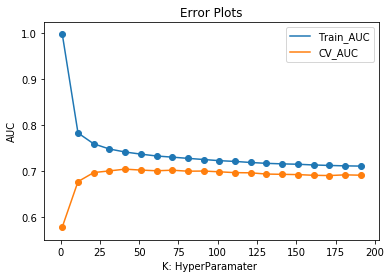

In [204]:

train_auc=[]
cv_auc=[]
K = list(range(1,200,10))
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    neigh.fit(sent_vectors_train,Y_train)
    Y_train_pred= neigh.predict_proba(sent_vectors_train)[:,1]
    Y_cv_pred = neigh.predict_proba(sent_vectors_cv)[:,1]
    #we append the predicted values to train_auc & cv_auc list
    train_auc.append(roc_auc_score(Y_train,Y_train_pred)) #Train data predictions
    cv_auc.append(roc_auc_score(Y_cv,Y_cv_pred)) #Cross Validation data predictions
    
#Will  plolt Error plots between Train and CV Data predictions
plt.plot(K,train_auc,label='Train_AUC')
plt.scatter(K,train_auc)
plt.plot(K,cv_auc,label='CV_AUC')
plt.scatter(K,cv_auc)
plt.legend()
plt.xlabel("K: HyperParamater ")
plt.ylabel("AUC")
plt.title("Error Plots")
plt.show()

In [206]:
#Based on the above plot we can see that optimal K lies between 10 - 40
# we will calucalte cross-validation scores of k in range of 10-40
from sklearn.model_selection import cross_val_score

neighb = list(range(10,40,5))
cv_score = []
for i in tqdm(neighb):
    knn=KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    scores=cross_val_score(knn,sent_vectors_train,Y_train,cv=10,scoring='accuracy')
    cv_score.append(scores.mean())

100%|████████████████████████████████████████████| 6/6 [00:24<00:00,  4.09s/it]


Optimal-K:  35


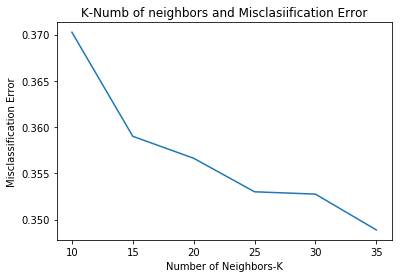

Misclassification error for each K:  [0.37  0.359 0.357 0.353 0.353 0.349]


In [207]:
#Will calculate Misclassification Error
MSE = [1 -x for x in cv_score]
optimal_k7=neighb[MSE.index(min(MSE))]
print("Optimal-K: ",optimal_k7)

#Plotting Misclassification vs K
plt.plot(neighb,MSE)
plt.title('K-Numb of neighbors and Misclasiification Error')
plt.xlabel('Number of Neighbors-K')
plt.ylabel('Misclassification Error')
plt.show()

print("Misclassification error for each K: ",np.round(MSE,3))

In [208]:
from sklearn.metrics import accuracy_score

#Now will instantiate learning model with optimal K
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k7,algorithm='kd_tree')
#Fitting the model
knn_optimal.fit(sent_vectors_train,Y_train)
#will predict the response on test data
pred=knn_optimal.predict(sent_vectors_test)

#Evaluating accuracy now
train_acc = knn_optimal.score(sent_vectors_train,Y_train)
train_err = 1 - train_acc
test_acc  = accuracy_score(Y_test,pred)
test_err  = 1 - test_acc

print("Training Accuracy: ",train_acc)
print("Training Error:    ",train_err)
print("Testing Accuracy:  ",test_acc)
print("Testing Error:     ",test_err)

Training Accuracy:  0.6785
Training Error:     0.3215
Testing Accuracy:   0.64
Testing Error:      0.36


Text(0.5,1,'AUC - Error Plots Avg W2V')

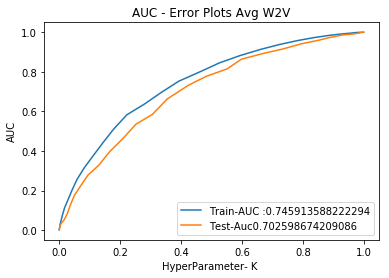

In [209]:
#https://www.programcreek.com/python/example/81207/sklearn.metrics.roc_curve
#Will Plot the Area Under Curve(AUC)

train_fpr,train_tpr,thresholds = roc_curve(Y_train,knn_optimal.predict_proba(sent_vectors_train)[:,1] )
test_fpr,test_tpr,thresholds = roc_curve(Y_test,knn_optimal.predict_proba(sent_vectors_test)[:,1])
plt.plot(train_fpr,train_tpr,label='Train-AUC :'+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label='Test-Auc'+str(auc(test_fpr,test_tpr)))
AUC7=str(auc(test_fpr,test_tpr))
plt.legend()
plt.xlabel("HyperParameter- K ")
plt.ylabel("AUC")
plt.title("AUC - Error Plots Avg W2V")


In [210]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Train Confusion Matrix -Avg W2V (Kd-Tree)")
print(confusion_matrix(Y_train,knn_optimal.predict(sent_vectors_train)))
print("Test Confusion Matrix - Avg W2V (Kd-Tree)")
print(confusion_matrix(Y_test,knn_optimal.predict(sent_vectors_test)))

Train Confusion Matrix -Avg W2V (Kd-Tree)
[[2871 1117]
 [1455 2557]]
Test Confusion Matrix - Avg W2V (Kd-Tree)
[[703 309]
 [411 577]]


In [211]:
#Classification Report:
from sklearn.metrics import classification_report
print(classification_report(Y_test,pred))

             precision    recall  f1-score   support

          0       0.63      0.69      0.66      1012
          1       0.65      0.58      0.62       988

avg / total       0.64      0.64      0.64      2000



### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [212]:
# Please write all the code with proper documentation
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))


In [213]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████████████████████████████████| 8000/8000 [01:38<00:00, 81.52it/s]


In [214]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████████████████████████████████| 2000/2000 [00:25<00:00, 79.21it/s]


In [215]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████████████████████████████████| 2000/2000 [00:24<00:00, 80.55it/s]


100%|██████████████████████████████████████████| 20/20 [02:32<00:00,  7.63s/it]


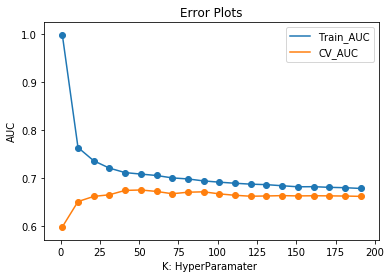

In [216]:
train_auc=[]
cv_auc=[]
K = list(range(1,200,10))
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    neigh.fit(tfidf_sent_vectors_train,Y_train)
    Y_train_pred= neigh.predict_proba(tfidf_sent_vectors_train)[:,1]
    Y_cv_pred = neigh.predict_proba(tfidf_sent_vectors_cv)[:,1]
    #we append the predicted values to train_auc & cv_auc list
    train_auc.append(roc_auc_score(Y_train,Y_train_pred)) #Train data predictions
    cv_auc.append(roc_auc_score(Y_cv,Y_cv_pred)) #Cross Validation data predictions
    
#Will  plolt Error plots between Train and CV Data predictions
plt.plot(K,train_auc,label='Train_AUC')
plt.scatter(K,train_auc)
plt.plot(K,cv_auc,label='CV_AUC')
plt.scatter(K,cv_auc)
plt.legend()
plt.xlabel("K: HyperParamater ")
plt.ylabel("AUC")
plt.title("Error Plots")
plt.show()

In [217]:
# we will calucalte cross-validation scores of k in range of 35-75
from sklearn.model_selection import cross_val_score

neighb = list(range(20,50,5))
cv_score = []
for i in tqdm(neighb):
    knn=KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    scores=cross_val_score(knn,tfidf_sent_vectors_train,Y_train,cv=10,scoring='accuracy')
    cv_score.append(scores.mean())

100%|████████████████████████████████████████████| 6/6 [00:30<00:00,  5.15s/it]


Optimal-K:  20


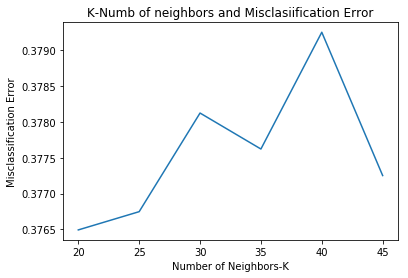

Misclassification error for each K:  [0.376 0.377 0.378 0.378 0.379 0.377]


In [218]:
#Will calculate Misclassification Error
MSE = [1 -x for x in cv_score]
optimal_k8=neighb[MSE.index(min(MSE))]
print("Optimal-K: ",optimal_k8)

#Plotting Misclassification vs K
plt.plot(neighb,MSE)
plt.title('K-Numb of neighbors and Misclasiification Error')
plt.xlabel('Number of Neighbors-K')
plt.ylabel('Misclassification Error')
plt.show()

print("Misclassification error for each K: ",np.round(MSE,3))

In [219]:
from sklearn.metrics import accuracy_score

#Now will instantiate learning model with optimal K
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k8,algorithm='kd_tree')
#Fitting the model
knn_optimal.fit(tfidf_sent_vectors_train,Y_train)
#will predict the response on test data
pred=knn_optimal.predict(tfidf_sent_vectors_test)

#Evaluating accuracy now
train_acc = knn_optimal.score(tfidf_sent_vectors_train,Y_train)
train_err = 1 - train_acc
test_acc  = accuracy_score(Y_test,pred)
test_err  = 1 - test_acc

print("Training Accuracy: ",train_acc)
print("Training Error:    ",train_err)
print("Testing Accuracy:  ",test_acc)
print("Testing Error:     ",test_err)

Training Accuracy:  0.677625
Training Error:     0.32237499999999997
Testing Accuracy:   0.6145
Testing Error:      0.38549999999999995


Text(0.5,1,'AUC - Error Plots')

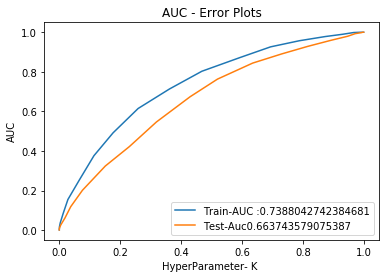

In [220]:
#https://www.programcreek.com/python/example/81207/sklearn.metrics.roc_curve
#Will Plot the Area Under Curve(AUC)

train_fpr,train_tpr,thresholds = roc_curve(Y_train,knn_optimal.predict_proba(tfidf_sent_vectors_train)[:,1] )
test_fpr,test_tpr,thresholds = roc_curve(Y_test,knn_optimal.predict_proba(tfidf_sent_vectors_test)[:,1])
plt.plot(train_fpr,train_tpr,label='Train-AUC :'+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label='Test-Auc'+str(auc(test_fpr,test_tpr)))
AUC8 = str(auc(test_fpr,test_tpr))
plt.legend()
plt.xlabel("HyperParameter- K ")
plt.ylabel("AUC")
plt.title("AUC - Error Plots")

In [222]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Train Confusion Matrix ")
print(confusion_matrix(Y_train,knn_optimal.predict(tfidf_sent_vectors_train)))
print("Test Confusion Matrix ")
print(confusion_matrix(Y_test,knn_optimal.predict(tfidf_sent_vectors_test)))

Train Confusion Matrix 
[[2955 1033]
 [1546 2466]]
Test Confusion Matrix 
[[689 323]
 [448 540]]


In [223]:
#Classification Report:
from sklearn.metrics import classification_report
print(classification_report(Y_test,pred))

             precision    recall  f1-score   support

          0       0.61      0.68      0.64      1012
          1       0.63      0.55      0.58       988

avg / total       0.62      0.61      0.61      2000



# [6] Conclusions

In [226]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
comparison = PrettyTable()
comparison.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]
comparison.add_row(["BOW", 'brute', optimal_k, np.round(float(AUC1),3)])
comparison.add_row(["TFIDF", 'brute', optimal_k2, np.round(float(AUC2),3)])
comparison.add_row(["AVG W2V", 'brute', optimal_k3, np.round(float(AUC3),3)])
comparison.add_row(["Weighted W2V", 'brute', optimal_k4,np.round(float(AUC4),3)])
comparison.add_row(["BOW", 'kd_tree', optimal_k5, np.round(float(AUC5),3)])
comparison.add_row(["TFIDF", 'kd_tree', optimal_k6, np.round(float(AUC6),3)])
comparison.add_row(["AVG W2V", 'kd_tree', optimal_k7, np.round(float(AUC7),3)])
comparison.add_row(["Weighted W2V", 'kd_tree', optimal_k8, np.round(float(AUC8),3)])
print(comparison)

+--------------+---------+----------------+-------+
|  Vectorizer  |  Model  | Hyperparameter |  AUC  |
+--------------+---------+----------------+-------+
|     BOW      |  brute  |       65       | 0.769 |
|    TFIDF     |  brute  |      330       | 0.919 |
|   AVG W2V    |  brute  |       45       | 0.718 |
| Weighted W2V |  brute  |       60       | 0.683 |
|     BOW      | kd_tree |       75       | 0.762 |
|    TFIDF     | kd_tree |      125       | 0.901 |
|   AVG W2V    | kd_tree |       35       | 0.703 |
| Weighted W2V | kd_tree |       20       | 0.664 |
+--------------+---------+----------------+-------+


From the above statistics , we can observe that Tf-Idf with hyperparameter k as 330NN With the Brute Force Algorithm given best AUC <br>
For compatible model which will not over fit or under fit, we have split our data into Train,CV,Test<br>
Even though we have trained our model using Train Data, we cannot be sure that our model works same on unseen data as our data is not splitted on time base